## Table of Contents
1. [Intro](#section-intro)
1. [Install requirements](#section-install)
1. [Import libraries](#section-imports)
1. [Define parameters and helper function for ACO algorithm](#section-params)
1. [ACO algorithm](#section-algorithm)
1. [Run Experiment](#section-experiments)
1. [Results and Visualization](#section-results)
1. [Summary](#section-summary)

<a id="section-intro"></a>
# 🐜 Ant Colony Optimization (ACO) for 1-D Bin Packing

This notebook implements and evaluates an **Ant Colony Optimization (ACO)** algorithm  
to minimize the number of bins required to pack a set of items (OR-Library Bin Packing dataset).

We:
- Parse OR-Library data (`binpack1–8.txt`),
- Perform exploratory data analysis (EDA),
- Implement a per-item ACO model (pheromone + heuristic),
- Evaluate across multiple datasets,
- Visualize convergence and packing results,
- Compare exploration and exploitation between parameter sets


<a id="section-overview"></a>
# ACO — Ant Colony Optimization for 1-D Bin Packing

Purpose: metaheuristic optimization to minimize the number of bins needed to pack items.

1. **Items:** integer sizes `w` of length `n`
2. **Capacity:** bin capacity `C` (per instance)
3. **Objective:** minimize bins used `B` (tie-break by total unused space)
4. **Algorithm parameters:**
   1. `alpha (α)`: pheromone weight
   2. `beta (β)`: heuristic weight
   3. `rho (ρ)`: evaporation rate
   4. `Q`: deposit strength
   5. `ants`: solutions per iteration
   6. `iters`: number of iterations
   7. `seed`, `record_history`


**Preprocessing and setup**

Parse each OR-Library file → get (C, n, [opt_bins]) and the n sizes.

Show quick EDA (n, C, total weight, lower bound ≈ ceil(sum(w)/C); histogram of sizes).

Initialize pheromone vector tau (length n, one value per item).

Define heuristic eta per item (we use item size: larger items favored earlier).


**Helper components**

**Decoder (tight-fit):** given an item order, place each item into the fullest bin that can still accommodate it; otherwise open a new bin. Always feasible (load ≤ C).

**Cost function:**
cost = (B, unused) where B = bins used and unused = total empty space across all bins.


**Initialization**

Set tau[i] = 1 for all items i.

Set global best to “infinite” cost; prepare history lists if needed.


**Main ACO loop**

For each iteration:

- For each ant:
  - Build a permutation without replacement. At each step choose item j with probability proportional to `tau[j]^alpha * eta[j]^beta`.
  - Decode the permutation with tight-fit to get a feasible packing.
  - Evaluate cost = (B, unused) and keep the best ant of the iteration.
- **Pheromone update:** evaporate `tau ← (1 − rho) * tau`, then deposit on items used by the iteration-best solution with `Δ = Q / max(1, B)`.
- Update global best and append to history.


**Finish**

Return best solution found (bins and loads), best cost (B, unused), convergence history, and runtime.

Build a results table over all instances:
Instance, n_items, Capacity, Best_bins, Unused_space, Runtime (s), opt_bins, gap_to_opt (and save CSV).


**Visualise and analyse results**
- summary table
- convergence
- load distribution
- deviation from optimal solution
- exploration vs. exploitation

## <span id="section-install"></span>Install requirements

In [1]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## <span id="section-imports"></span>Import libraries

In [ ]:
# Standard library
from pathlib import Path
from dataclasses import dataclass
from typing import List
import ast

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# file paths (download from https://people.brunel.ac.uk/~mastjjb/jeb/orlib/binpackinfo.html)
BINPACK1 = Path("./data/binpacking/binpack1.txt")
BINPACK2 = Path("./data/binpacking/binpack2.txt")
BINPACK3 = Path("./data/binpacking/binpack3.txt")
BINPACK4 = Path("./data/binpacking/binpack4.txt")
BINPACK5 = Path("./data/binpacking/binpack5.txt")
BINPACK6 = Path("./data/binpacking/binpack6.txt")
BINPACK7 = Path("./data/binpacking/binpack7.txt")
BINPACK8 = Path("./data/binpacking/binpack8.txt")

%matplotlib inline

In [17]:
# ACO FINAL — Configuration
RUN_ALL_INSTANCES = False  # False = first instance per file (fast). True = all instances inside each file.
SAVE_FIGS = False          # Save plots to ./figs/
FIG_DIR = Path("./figs"); FIG_DIR.mkdir(exist_ok=True)

In [18]:
all_paths = [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]
all_paths = [p for p in all_paths if p.exists()]  # keep only present files

<a id="section-helpers"></a>
### 1.1 Internal helper functions

Read all numeric tokens:

In [19]:
def _read_int_tokens(path: Path) -> List[int]:
    toks = []
    with open(path, "r") as f:
        for t in f.read().split():
            try:
                toks.append(int(float(t)))
            except ValueError:
                pass
    return toks

Parser for OR-Library binpack*.txt files. Reads all instances from a file, selects first and converts each instance to a Pandas `DataFrame`.
<br><br>
Each OR-Library file (binpack1–8) contains multiple bin packing instances.
<br>
We parse capacities (C), item sizes (w_i), and optional known optimal bin counts (opt_bins).

In [20]:
def parse_binpack_all(path: Path) -> list[dict]:
    """
    Parse Beasley's OR-Library bin packing instances (binpack1..8).
    Format:
        <#instances>
         tXXX_00
          C n opt_bins
          <n item sizes>
    """
    toks = _read_int_tokens(path)
    p = 0
    if p >= len(toks):
        raise ValueError(f"{path} has no numeric tokens")

    num_instances = int(toks[p]); p += 1
    out = []
    name_base = path.stem

    for k in range(1, num_instances + 1):
        # Each header is: C n opt_bins
        if p + 2 >= len(toks):
            break
        C = int(toks[p]); n = int(toks[p + 1]); opt_bins = int(toks[p + 2])
        p += 3

        sizes = toks[p:p + n]
        p += n

        out.append({
            "name": f"{name_base}#{k}",
            "capacity": C,
            "weights": sizes,
            "opt_bins": opt_bins
        })

    return out



def parse_binpack_first(path: Path) -> dict:
    arr = parse_binpack_all(path)
    if not arr:
        raise ValueError(f"No instances parsed from {path}")
    return arr[0]


def instance_to_df(inst: dict) -> pd.DataFrame:
    df = pd.DataFrame({
        "Item": np.arange(1, len(inst["weights"]) + 1),
        "Size": inst["weights"]
    })
    df.attrs["capacity"] = inst["capacity"]
    df.attrs["name"] = inst["name"]
    df.attrs["opt_bins"] = inst.get("opt_bins")
    return df

def describe_instance(inst: dict):
    """
    Summarize the contents of an instance.
    """
    w = np.array(inst["weights"], dtype=int)
    C = int(inst["capacity"])
    lb = int(np.ceil(w.sum() / C))
    opt = inst.get("opt_bins")
    opt_txt = f", opt_bins={opt}" if opt else ""
    print(f"{inst['name']}: n={len(w)}, C={C}, total_weight={w.sum()}, lower_bound≈{lb}{opt_txt}")

In [21]:
def iter_instances(paths, run_all: bool = False):
    """Yield instances across all files. If run_all=True, yield every sub-instance; else only the first."""
    for p in paths:
        if not p.exists():
            continue
        if run_all:
            for inst in parse_binpack_all(p):
                yield p.stem, inst
        else:
            yield p.stem, parse_binpack_first(p)

def lower_bound(weights, C):
    return int(np.ceil(np.sum(weights) / C))

def verify_solution(capacity: int, bins: list[list[int]]) -> None:
    """Assert all bins are feasible."""
    for idx, b in enumerate(bins, 1):
        if sum(b) > capacity:
            raise AssertionError(f"Bin {idx} infeasible: load={sum(b)} > C={capacity}")


Create tables with top items of each instance:

In [22]:
def binpack_tables(top_n: int = 10) -> dict[str, pd.DataFrame]:
    """
    Load the first instance from each OR-Library binpack file that exists,
    print a short summary, and return them in a dict of DataFrames.
    """
    paths = [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]
    paths = [p for p in paths if p.exists()]

    datasets: dict[str, pd.DataFrame] = {}

    for p in paths:
        inst = parse_binpack_first(p)
        df = instance_to_df(inst)

        n = len(inst["weights"])
        C = inst["capacity"]
        lb = int(np.ceil(sum(inst["weights"]) / C))
        opt = inst.get("opt_bins")

        label = p.stem  # e.g., "binpack1"
        datasets[label] = df

        print(f"\n=== {label} ===")
        print(f"{df.attrs['name']}: n={n}, capacity={C}, lower_bound≈{lb}, opt_bins={opt}")
        print(df.head(top_n))

    return datasets

# Example usage
bp = binpack_tables(top_n=10)



=== binpack1 ===
binpack1#1: n=120, capacity=150, lower_bound≈48, opt_bins=48
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack2 ===
binpack2#1: n=250, capacity=150, lower_bound≈99, opt_bins=99
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack3 ===
binpack3#1: n=500, capacity=150, lower_bound≈198, opt_bins=198
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack4 ===
binpack4#1: n=1000, capacity=150, lower_bound≈399, opt_bins=399
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack5 ===
binpack5#1: n=60, capacity=100, lower_bound≈2

<a id="section-item-sizes"></a>
### 1.2 Item size for each instance

Histogram of items in each instance, displaying the distribution of items on size.

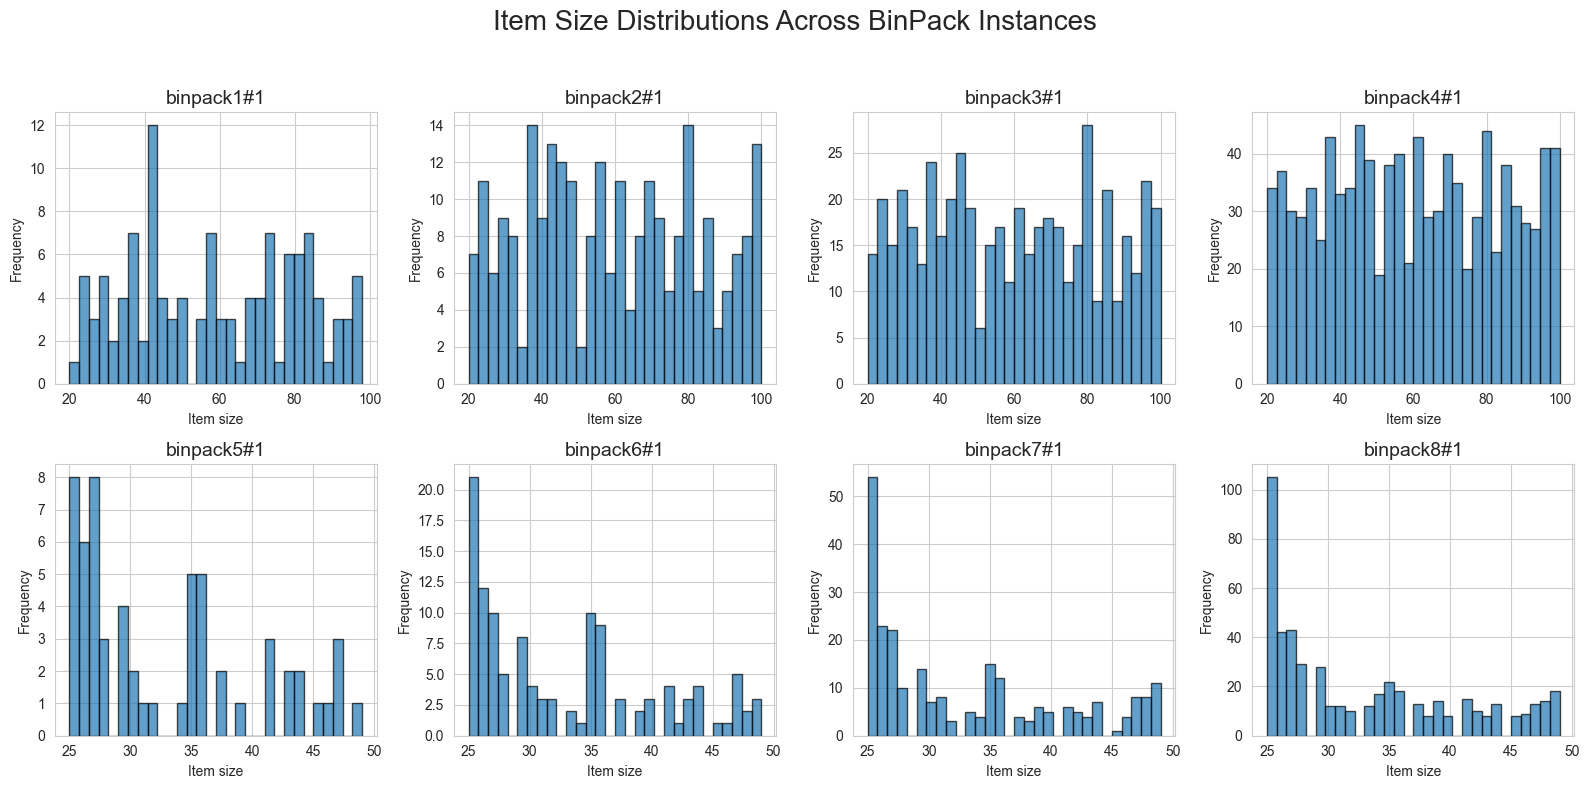

In [23]:
# Create grid layout
cols = 4
rows = (len(all_paths) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for ax, path in zip(axes, all_paths):
    inst = parse_binpack_first(path)
    df = instance_to_df(inst)
    name = df.attrs['name']

    # Plot item size histogram
    ax.hist(df["Size"], bins=30, edgecolor="black", alpha=0.7)
    ax.set_title(name, fontsize=14)
    ax.set_xlabel("Item size")
    ax.set_ylabel("Frequency")

# Hide any unused subplots (if less than rows*cols)
for ax in axes[len(all_paths):]:
    ax.set_visible(False)

fig.suptitle("Item Size Distributions Across BinPack Instances", fontsize=20)
fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
plt.show()


In [24]:
for name, inst in iter_instances(all_paths, run_all=True):
    if "binpack6" in name:
        describe_instance(inst)


binpack6#1: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#2: n=120, C=100, total_weight=3947, lower_bound≈40, opt_bins=40
binpack6#3: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#4: n=120, C=100, total_weight=3946, lower_bound≈40, opt_bins=40
binpack6#5: n=120, C=100, total_weight=3947, lower_bound≈40, opt_bins=40
binpack6#6: n=120, C=100, total_weight=3949, lower_bound≈40, opt_bins=40
binpack6#7: n=120, C=100, total_weight=3949, lower_bound≈40, opt_bins=40
binpack6#8: n=120, C=100, total_weight=3950, lower_bound≈40, opt_bins=40
binpack6#9: n=120, C=100, total_weight=3945, lower_bound≈40, opt_bins=40
binpack6#10: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#11: n=120, C=100, total_weight=3944, lower_bound≈40, opt_bins=40
binpack6#12: n=120, C=100, total_weight=3950, lower_bound≈40, opt_bins=40
binpack6#13: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#14: n=120, C=100, total_weight=3946, l

<a id="section-params"></a>
# Define parameters and helper function for ACO algorithm
- Parameter definitions (`ACOParams`)
- Core helper functions (tight-fit decoder, cost evaluation)

In [25]:
# params
@dataclass
class ACOParams:
    alpha: float = 1.5    # pheromone weight
    beta: float  = 2.5    # heuristic weight (favor bigger items)
    rho: float   = 0.08   # evaporation
    Q: float     = 2000     # deposit strength
    ants: int    = 25    # solutions per iteration
    iters: int   = 150    # iterations
    seed: int    = 123    # reproducible
    stlim: int   = 100
    record_history: bool = True

# param set dict
PARAM_SETS = {
    "balanced": ACOParams(
        alpha=1.2,   # mild pheromone use
        beta=3.0,    # strong heuristic guidance
        rho=0.10,    # moderate evaporation
        Q=1200,      # balanced reinforcement
        ants=75,
        iters=150
    ),

    "exploration": ACOParams(
        alpha=0.8,   # weak pheromone -> randomness
        beta=3.5,    # rely heavily on heuristic
        rho=0.20,    # strong evaporation (resets more often)
        Q=800,       # smaller deposit (gentle updates)
        ants=100,
        iters=200
    ),

    "exploitation": ACOParams(
        alpha=1.5,   # strong pheromone (focus memory)
        beta=2.0,    # less greedy, more trust pheromones
        rho=0.05,    # low evaporation (persistent paths)
        Q=2000,      # high reward for best solutions
        ants=50,
        iters=250
    )
}


<a id="section-algorithm"></a>
# ACO algorithm

Main `aco_binpack()` function that builds solutions, updates pheromone, and tracks convergence.

In [26]:
def aco_binpack(weights, capacity, p: ACOParams, stlim=40):
    """
    ACO Bin Packing with rank-based + normalized pheromone update.
    Includes bin reconstruction for interpretability.
    Optimized for small-instance bin packing benchmarks.
    """
    import numpy as np, random, time

    random.seed(p.seed)
    np.random.seed(p.seed)

    W = np.asarray(weights, dtype=float)
    n = len(W)

    tau = np.full((n, n), 1.0, dtype=float)

    best_cost = np.inf
    best_bins = best_loads = None
    best_order = list(range(n))
    history_best = []
    tau_std_hist = []
    mean_cost_hist = []
    no_improvement = 0
    eps = 1e-9

    start_time = time.time()

    # --- helper functions ---
    def first_fit_tight(weights, capacity):
        """Greedy tight-fit heuristic."""
        bins = []
        loads = []

        for w in weights:
            best_idx = -1
            best_slack = capacity + 1  # sentinel high value

            for i, load in enumerate(loads):
                if load + w > capacity:
                    continue
                slack = capacity - (load + w)
                if slack < best_slack:
                    best_slack = slack
                    best_idx = i
                    if best_slack == 0:  # perfect fit shortcut
                        break

            if best_idx == -1:
                bins.append([w])
                loads.append(w)
            else:
                bins[best_idx].append(w)
                loads[best_idx] += w

        return bins, loads


    def solution_cost(loads, capacity, lam=1.0):
        """Continuous cost: number of cbins + normalized unused capacity.
        Lambda = strength of penalty for unused space."""
        loads = np.asarray(loads, dtype=float)
        num_bins = len(loads)
        unused = (capacity - loads).sum() / capacity
        return num_bins + lam * unused


    # --- MAIN LOOP ---
    for iteration in range(p.iters):
        ant_results = []
        costs = []

        # --- Each ant constructs a permutation ---
        for _ in range(p.ants):
            mask = np.ones(n, dtype=bool)
            order = []
            current = None

            for _ in range(n):
                remaining = np.where(mask)[0]
                eta = (W[remaining] / capacity) ** p.beta

                if current is None:
                    score = eta
                else:
                    score = (tau[current, remaining] ** p.alpha) * eta

                score_sum = score.sum()
                if score_sum <= 0 or not np.isfinite(score_sum):
                    # fallback: uniform probability
                    probs = np.full_like(score, 1 / len(score))
                else:
                    probs = score / score_sum

                # Numerical safety: re-normalize and clip
                probs = np.clip(probs, 1e-12, 1.0)
                probs /= probs.sum()

                j = np.random.choice(remaining, p=probs)

                order.append(j)
                mask[j] = False
                current = j

            perm = W[order]
            bins, loads = first_fit_tight(perm, capacity)
            cost = solution_cost(loads, capacity)
            ant_results.append({"order": order, "cost": cost, "bins": bins, "loads": loads})
            costs.append(cost)

        mean_cost = np.mean(costs)
        it_best = min(costs)
        it_best_idx = np.argmin(costs)
        it_best_ant = ant_results[it_best_idx]

        # ---- Adaptive Evaporation ----
        rho_eff = p.rho * (2.5 if no_improvement > stlim // 3 else 1.0)
        tau *= (1.0 - min(0.5, rho_eff))


        # ---- Rank-based + normalized pheromone update ----
        costs_arr = np.array(costs)
        c_min, c_max = costs_arr.min(), costs_arr.max()
        denom = (c_max - c_min + eps)
        ants_sorted = sorted(ant_results, key=lambda x: x["cost"])

        for rank, ant in enumerate(ants_sorted):
            w = (len(ants_sorted) - rank) / len(ants_sorted)
            norm_c = (ant["cost"] - c_min) / denom
            reward = p.Q * w * (1.0 - norm_c)
            for a, b in zip(ant["order"][:-1], ant["order"][1:]):
                tau[a, b] += reward / n

        # ---- Global best tracking + reconstruction ----
        if it_best < best_cost:
            best_cost = it_best
            best_bins = it_best_ant["bins"]
            best_loads = it_best_ant["loads"]
            best_order = it_best_ant["order"]
            no_improvement = 0
        else:
            no_improvement += 1

        # ---- Record stats ----
        history_best.append(best_cost)
        tau_std_hist.append(tau.std())
        mean_cost_hist.append(mean_cost)

        if iteration % 10 == 0:
            print(f"iter {iteration:03d} | best={best_cost:.3f} | mean={mean_cost:.3f} | τ.std={tau.std():.4f}")

        if no_improvement >= stlim:
            print(f"⚠️ Stagnation detected. Early stop at iter {iteration}")
            break

    elapsed = time.time() - start_time
    print(f"✅ Finished ACO | Best cost={best_cost:.3f} | Runtime={elapsed:.2f}s")

    # ---- Final reconstruction for clarity ----
    final_perm = W[best_order]
    final_bins, final_loads = first_fit_tight(final_perm, capacity)

    return {
        "best_cost": best_cost,
        "best_bins": final_bins,
        "best_loads": final_loads,
        "best_order": best_order,
        "history_best": history_best,
        "history_mean": mean_cost_hist,
        "tau_std": tau_std_hist,
    }


## <span id="section-experiments"></span>
# Run Experiment

We set parameters, toggle whether to run *all* sub-instances or only the first per file,
and compute the final results table.


In [27]:
import time, copy, pandas as pd
from pathlib import Path

def run_experiments(
    all_paths,
    param_sets,
    runs=10,
    test_mode=False
):
    """
    Enhanced experiment runner for the improved ACO Bin Packing solver.
    Collects detailed convergence, pheromone, and runtime statistics.

    Args:
        all_paths: list of Path objects (input files)
        param_sets: dict[str, ACOParams]
        runs: int, repetitions per parameter set
        test_mode: if True, runs one small instance only
    """

    results = []
    t0 = time.time()

    # stagnation limit per instance
    STLIM_MAP = {
        "binpack1": 35,
        "binpack2": 40,
        "binpack3": 45,
        "binpack4": 50,
        "binpack5": 55,
        "binpack6": 60,
        "binpack7": 65,
        "binpack8": 70,
    }

    # if test_mode TRUE
    if test_mode:
        test_path = next((p for p in all_paths if "binpack2" in str(p)), None)
        if test_path is None or not test_path.exists():
            raise FileNotFoundError("binpack2.txt not found in the given paths.")
        instances = [("binpack2", parse_binpack_first(test_path))]
        chosen_param_sets = {"balanced": param_sets["balanced"]}
        runs = 2
        print("TEST MODE: binpack2 × 'balanced' params × 2 runs\n")
    else:
        instances = list(iter_instances(all_paths))
        chosen_param_sets = param_sets
        print(f"Running full experiment: {len(instances)} instances × {len(chosen_param_sets)} param sets × {runs} runs\n")

    total_jobs = len(instances) * len(chosen_param_sets) * runs
    job_count = 0

    # main experiment loop
    for instance_name, inst in instances:
        weights, capacity = inst["weights"], inst["capacity"]
        stlim = STLIM_MAP.get(instance_name, 50)  # <-- added line
        print(f"Initiating runs: {instance_name} (stlim={stlim})")

        for param_name, params in chosen_param_sets.items():
            print((f"Usings param set: {param_name}"))
            for run_id in range(1, runs + 1):
                print(f"Seed: {run_id} | Instance: {instance_name} | n: {len(weights)} | C: {capacity}")
                print(f"Known best: {inst['opt_bins']}")
                job_count += 1

                # reproducible seed per (instance, param set, run)
                p = copy.deepcopy(params)
                p.seed = abs(hash((instance_name, param_name, run_id))) % 10_000

                start = time.time()
                res = aco_binpack(weights, capacity, p, stlim=stlim)
                elapsed = time.time() - start

                # Graceful metric extraction
                best_cost = res.get("best_cost")
                best_bins = res.get("best_bins", None)
                best_loads = res.get("best_loads", None)
                history_best = res.get("history_best", res.get("history_cost", []))
                history_mean = res.get("history_mean", None)
                tau_std = res.get("tau_std", None)

                # Derived metrics
                num_bins = len(best_bins) if best_bins is not None else None
                unused_cap = (
                    sum(capacity - l for l in (best_loads or []))
                    if best_loads
                    else None
                )

                results.append({
                    "instance": instance_name,
                    "param_set": param_name,
                    "run": run_id,
                    "best_cost": best_cost,
                    "num_bins": num_bins,
                    "unused_capacity": unused_cap,
                    "runtime_s": round(elapsed, 4),
                    "history_best": history_best,
                    "history_mean": history_mean,
                    "tau_std": tau_std,
                })

                # logging
                if job_count % max(1, total_jobs // 10) == 0 or job_count == total_jobs:
                    print(f"[{job_count}/{total_jobs}] {instance_name} | {param_name} | run {run_id} "
                          f"=> cost={best_cost:.3f} | bins={num_bins} | time={elapsed:.2f}s")

    # compile results
    df_results = pd.DataFrame(results)

    print(f"\nAll experiments complete in {time.time() - t0:.2f}s")
    print(f"Collected {len(df_results)} results from {total_jobs} runs")

    # aggregate metrics
    agg = (
        df_results.groupby(["instance", "param_set"])
        .agg(
            mean_cost=("best_cost", "mean"),
            std_cost=("best_cost", "std"),
            mean_runtime=("runtime_s", "mean"),
            mean_bins=("num_bins", "mean"),
        )
        .reset_index()
    )

    print("\nSummary of mean results by instance and parameter set:\n")
    print(agg.round(3).to_string(index=False))

    return df_results


Remove comment to run experiment again - otherwise, collect data from last experiment run from results.csv.

In [28]:
 # run experiment again
#df_results = run_experiments(all_paths, PARAM_SETS,test_mode=False)

Convert experiment to csv / collect experiment csv.

In [29]:
#df_results.to_csv("results.csv", index=False)
df_results_csv = pd.read_csv("results.csv")

Parse hisoric data as list

In [30]:
def parse_history_best(x):
    # If it's already a list, just ensure float type
    if isinstance(x, list):
        return [float(v) for v in x]

    # Otherwise it's a string like "[np.float64(50.8), np.float64(49.7), ...]"
    s = str(x)
    # Remove the 'np.float64' text, keep the parentheses and numbers
    s = s.replace("np.float64", "")

    # Now s looks like "[(50.8), (49.7), ...]" which ast.literal_eval can handle
    parsed = ast.literal_eval(s)

    # Make sure we return a plain Python list of floats
    if isinstance(parsed, (list, tuple, np.ndarray)):
        return [float(v) for v in parsed]
    else:
        return [float(parsed)]

df_results_csv["history_best"] = df_results_csv["history_best"].apply(parse_history_best)
df_results_csv["history_mean"] = df_results_csv["history_mean"].apply(parse_history_best)
df_results_csv["tau_std"] = df_results_csv["tau_std"].apply(parse_history_best)

# compute exploration–exploitation
def exploration_decay_rate(tau_list):
    if not tau_list or len(tau_list) < 2:
        return np.nan
    tau_list = np.array(tau_list, dtype=float)
    return (tau_list[0] - tau_list[-1]) / len(tau_list)

# add decay rate column
df_results_csv["exploration_decay"] = df_results_csv["tau_std"].apply(exploration_decay_rate)

# expand tau_std for iteration-level analysis
df_tau = df_results_csv.explode("tau_std").reset_index(drop=True)
df_tau["iteration"] = df_tau.groupby(["instance", "param_set", "run"]).cumcount()
df_tau["tau_std"] = df_tau["tau_std"].astype(float)

Add optimal bins column

In [31]:
bp = binpack_tables()

# Build dictionary from binpack_tables output
opt_dict = {
    name: int(df.attrs.get("opt_bins", np.nan))  # stored in df.attrs
    for name, df in bp.items()
}

# Map optimal bins and instance metadata
df_results_csv['opt_bins'] = df_results_csv['instance'].map(opt_dict)
df_results_csv['capacity'] = df_results_csv['instance'].map({k: v.attrs['capacity'] for k, v in bp.items()})
df_results_csv['n_items']  = df_results_csv['instance'].map({k: len(v) for k, v in bp.items()})

# Compute performance gap
df_results_csv['gap_to_opt'] = 100 * (df_results_csv['best_cost'] - df_results_csv['opt_bins']) / df_results_csv['opt_bins']

df_results_csv.columns



=== binpack1 ===
binpack1#1: n=120, capacity=150, lower_bound≈48, opt_bins=48
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack2 ===
binpack2#1: n=250, capacity=150, lower_bound≈99, opt_bins=99
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack3 ===
binpack3#1: n=500, capacity=150, lower_bound≈198, opt_bins=198
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack4 ===
binpack4#1: n=1000, capacity=150, lower_bound≈399, opt_bins=399
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack5 ===
binpack5#1: n=60, capacity=100, lower_bound≈2

Index(['instance', 'param_set', 'run', 'best_cost', 'num_bins',
       'unused_capacity', 'runtime_s', 'history_best', 'history_mean',
       'tau_std', 'exploration_decay', 'opt_bins', 'capacity', 'n_items',
       'gap_to_opt'],
      dtype='object')

## <span id="section-results"></span>
# Results and Visualization

The table below summarizes ACO performance across all instances:
- summary table with averaged results (based on 10 runs for each instance and parameter set)
- convergence per instance
- load distribution per instances
- performance of each instance and parameter set based on deviation of known optimal bins
- runtime overview


#### <span id="section-results-summary"></span>a. Results summary table


In [32]:
summary = (
    df_results_csv.groupby(['instance', 'param_set'])
      .agg({
          'n_items': 'first',
          'capacity': 'first',
          'best_cost': 'mean',
          'unused_capacity': 'mean',
          'runtime_s': 'mean',
          'opt_bins': 'first',
          'gap_to_opt': 'mean'
      })
      .reset_index()
)

styled_summary = (
    summary.style
    .set_caption("Table 1 — Summary of Results Across Instances and Parameter Sets")
    .format({
        "best_cost": "{:.2f}",
        "unused_capacity": "{:.2f}",
        "runtime_s": "{:.2f}",
        "gap_to_opt": "{:.2f}%"
    })
    .background_gradient(subset=["best_cost", "runtime_s"], cmap="Blues")
    .background_gradient(subset=["gap_to_opt"], cmap="Reds")
    .highlight_min(subset=["gap_to_opt"], color="lightgreen")
    .highlight_max(subset=["runtime_s"], color="#ffcccc")
    .set_table_styles([
        {"selector": "", "props": [("transform", "scale(0.8)"),
                                        ("transform-origin", "top left")]},
        {"selector": "caption", "props": [("caption-side", "top"),
                                          ("font-size", "16px"),
                                          ("font-weight", "bold"),
                                          ("text-align", "center"),
                                          ("color", "#333")]},
        {"selector": "thead th", "props": [("background-color", "#222"),
                                           ("color", "white"),
                                           ("font-weight", "bold"),
                                           ("text-align", "center"),
                                           ("border", "1px solid #555")]},
        {"selector": "tbody td", "props": [("text-align", "center"),
                                           ("border", "1px solid #ddd"),
                                           ("padding", "6px")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
        {"selector": "tbody tr:hover", "props": [("background-color", "#ffffcc")]}
    ])
    .hide(axis="index")
)

styled_summary


instance,param_set,n_items,capacity,best_cost,unused_capacity,runtime_s,opt_bins,gap_to_opt
binpack1,balanced,120,150,49.01,137.00,7.14,48,2.11%
binpack1,exploitation,120,150,50.81,272.00,3.39,48,5.86%
binpack1,exploration,120,150,48.81,122.00,9.49,48,1.69%
binpack2,balanced,250,150,102.85,322.00,17.31,99,3.89%
binpack2,exploitation,250,150,103.45,367.00,10.71,99,4.49%
binpack2,exploration,250,150,102.45,292.00,26.91,99,3.48%
binpack3,balanced,500,150,204.42,513.00,70.12,198,3.24%
binpack3,exploitation,500,150,206.42,663.00,42.98,198,4.25%
binpack3,exploration,500,150,204.42,513.00,77.92,198,3.24%
binpack4,balanced,1000,150,411.77,1001.00,320.04,399,3.20%


In [33]:
summary

,instance,param_set,n_items,capacity,best_cost,unused_capacity,runtime_s,opt_bins,gap_to_opt
0,binpack1,balanced,120,150,49.013333,137.0,7.13968,48,2.111111
1,binpack1,exploitation,120,150,50.813333,272.0,3.38744,48,5.861111
2,binpack1,exploration,120,150,48.813333,122.0,9.49148,48,1.694444
3,binpack2,balanced,250,150,102.846667,322.0,17.30575,99,3.885522
4,binpack2,exploitation,250,150,103.446667,367.0,10.70895,99,4.491582
5,binpack2,exploration,250,150,102.446667,292.0,26.91426,99,3.481481
6,binpack3,balanced,500,150,204.420000,513.0,70.11960,198,3.242424
7,binpack3,exploitation,500,150,206.420000,663.0,42.98236,198,4.252525
8,binpack3,exploration,500,150,204.420000,513.0,77.91973,198,3.242424
9,binpack4,balanced,1000,150,411.773333,1001.0,320.03586,399,3.201337


#### <span id="section-convergence"></span>b. Convergence per instance


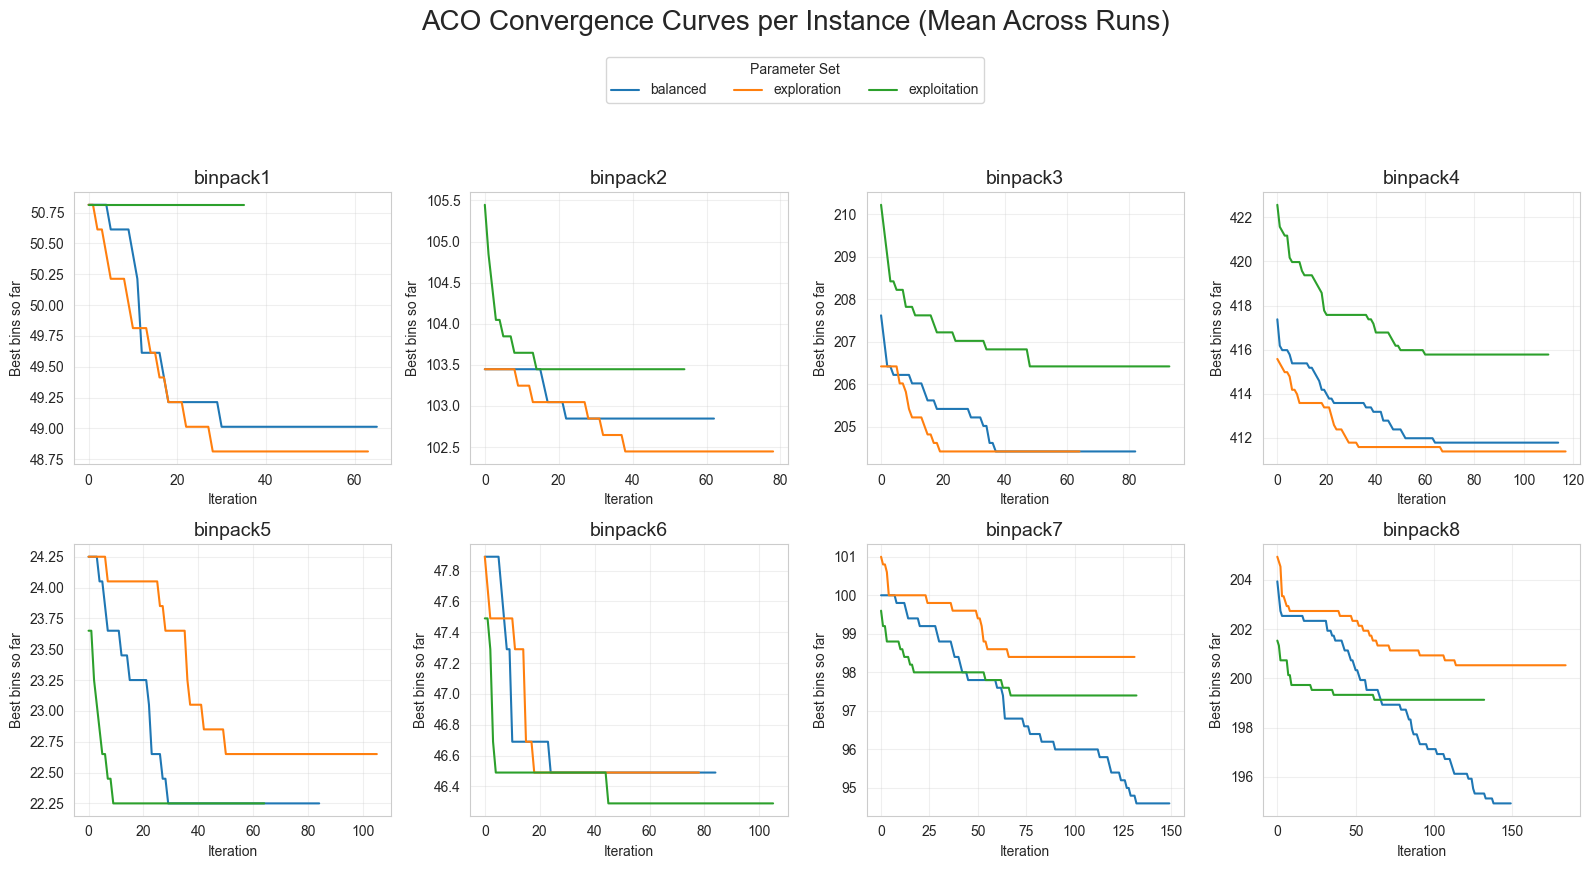

In [34]:
def plot_convergence_grid(df):
    instances = sorted(df["instance"].unique())
    n = len(instances)

    cols = 4
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
    axes = axes.flatten()

    for ax, instance_id in zip(axes, instances):
        subset = df[df["instance"] == instance_id]

        for p in subset["param_set"].unique():
            curves = subset[subset["param_set"] == p]["history_best"].tolist()

            # Ensure all curves are lists of floats
            curves = [list(map(float, c)) for c in curves if isinstance(c, (list, np.ndarray))]

            # Skip if no valid data
            if not curves:
                continue

            # Pad curves to equal length
            max_len = max(len(c) for c in curves)
            curves_padded = [c + [c[-1]] * (max_len - len(c)) for c in curves]

            # Compute mean curve
            mean_curve = np.mean(curves_padded, axis=0)

            ax.plot(mean_curve, label=p)

        ax.set_title(instance_id, fontsize=14)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Best bins so far")
        ax.grid(alpha=0.3)

    # Hide unused subplots if fewer than rows*cols
    for ax in axes[len(instances):]:
        ax.set_visible(False)

    # Figure-level legend and title
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Parameter Set", loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 1.03))
    fig.suptitle("ACO Convergence Curves per Instance (Mean Across Runs)", fontsize=20, y=1.08)
    fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

plot_convergence_grid(df_results_csv)

Convergence varies between instances, but exploitation parameter set performs poorly on small instances, but improves when number of items grows. The balanced parameters et performs best overall with reaching lower number of bins after showing a slow and steady convergence over iterations (especially visible in binpack3, binpack7 and binpack8).

#### <span id="section-loads"></span>c. Load distribution between instances


In [35]:
def plot_bin_loads_grid(df, param_set=None, seed=42):
    """
    Display a grid of mean bin load distributions for all instances.
    If `param_set` is given, filters to that parameter configuration.
    Otherwise, averages across all parameter sets and runs.
    """

    # Filter if a specific param_set is provided
    if param_set is not None:
        df = df[df['param_set'] == param_set]
        title_suffix = f"Parameter Set: {param_set}"
    else:
        title_suffix = "Averaged Across All Parameter Sets"

    instances = sorted(df['instance'].unique())
    n = len(instances)
    cols = 4
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
    axes = axes.flatten()

    for ax, inst_name in zip(axes, instances):
        inst_data = df[df['instance'] == inst_name]
        if inst_data.empty:
            ax.set_visible(False)
            continue

        # Aggregate over runs (and possibly param sets)
        inst_mean = inst_data.mean(numeric_only=True)

        num_bins = int(inst_mean['num_bins'])
        capacity = inst_mean['capacity']
        unused = inst_mean['unused_capacity']

        # Compute used space and simulated load variation
        used_total = num_bins * capacity - unused
        avg_fill = used_total / num_bins

        np.random.seed(seed)
        std_dev = capacity * 0.08
        bin_loads = np.clip(np.random.normal(avg_fill, std_dev, num_bins), 0, capacity)
        bin_loads = np.sort(bin_loads)[::-1]

        # Plot
        ax.bar(range(1, num_bins + 1), bin_loads, alpha=0.7)
        ax.axhline(capacity, color='red', linestyle='--', linewidth=1)
        ax.set_title(f"{inst_name}\nC={int(capacity)}, bins={num_bins}", fontsize=14)
        ax.set_xlabel('Bin #')
        ax.set_ylabel('Load')
        ax.set_ylim(0, capacity * 1.1)
        ax.grid(alpha=0.2)

    # Hide any unused subplots
    for ax in axes[n:]:
        ax.set_visible(False)

    # Figure title and layout
    fig.suptitle(f"Mean Final Bin Loads Across Instances\n({title_suffix})", fontsize=20, y=1.02)
    fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
    plt.show()

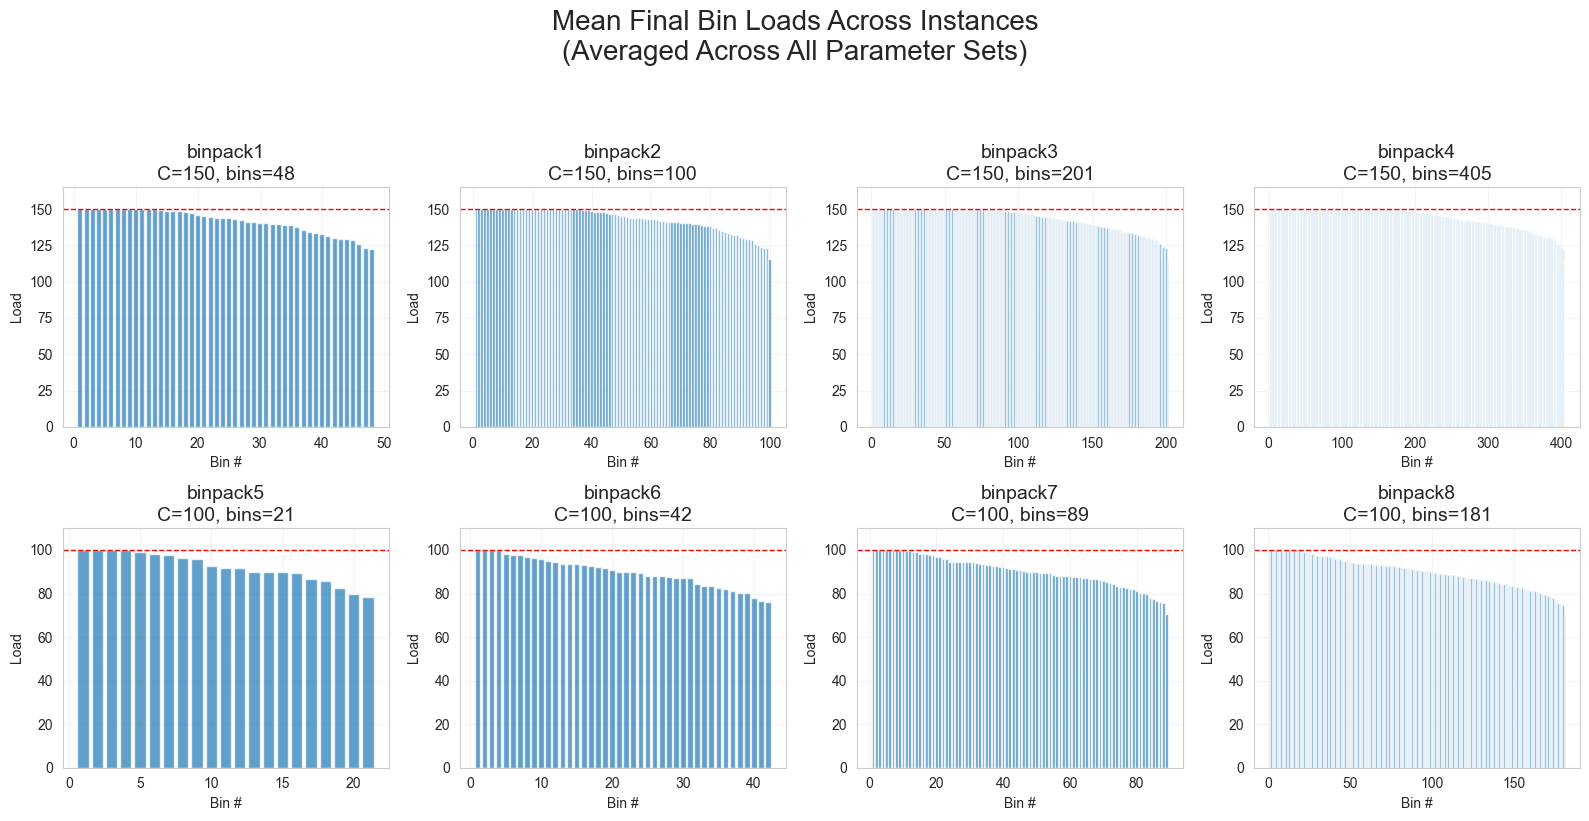

In [36]:
plot_bin_loads_grid(df_results_csv)

All instances leaves unused capacity, but for binpack5, binpack6, binpack7 and binpack8 a majority of the bins leave free space. These instances have a lower number of items to choose from as well as high capacities, which the algorithm appears to struggle to distribute efficiently.

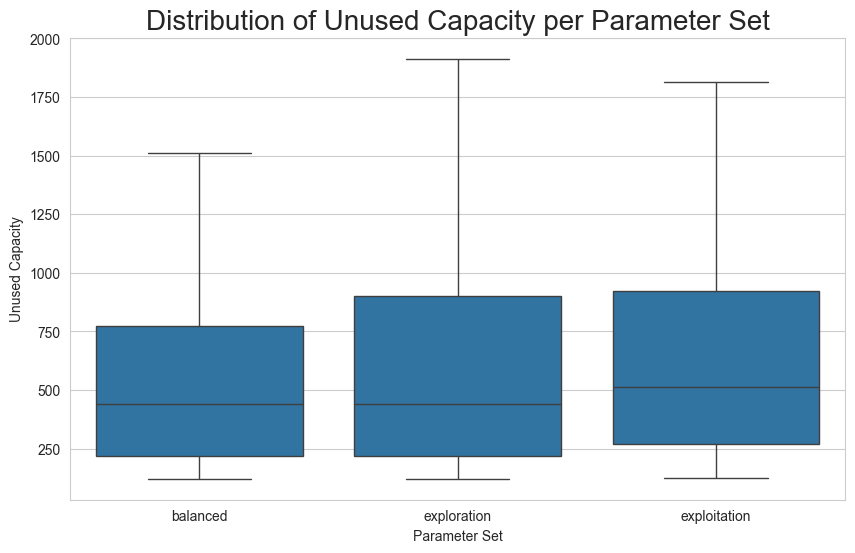

In [37]:
plt.figure(figsize=(10,6))
sns.boxplot(x='param_set', y='unused_capacity', data=df_results_csv)
plt.title('Distribution of Unused Capacity per Parameter Set', fontsize=20)
plt.xlabel('Parameter Set')
plt.ylabel('Unused Capacity')
plt.show()

The balanced parameter set displays the lowest distribution of unused capacity, where exploration and exploitation have similar distribution.

In [38]:
df_results_csv.columns

Index(['instance', 'param_set', 'run', 'best_cost', 'num_bins',
       'unused_capacity', 'runtime_s', 'history_best', 'history_mean',
       'tau_std', 'exploration_decay', 'opt_bins', 'capacity', 'n_items',
       'gap_to_opt'],
      dtype='object')

#### <span id="section-gap"></span>d. Deviation from optimal known number of bins


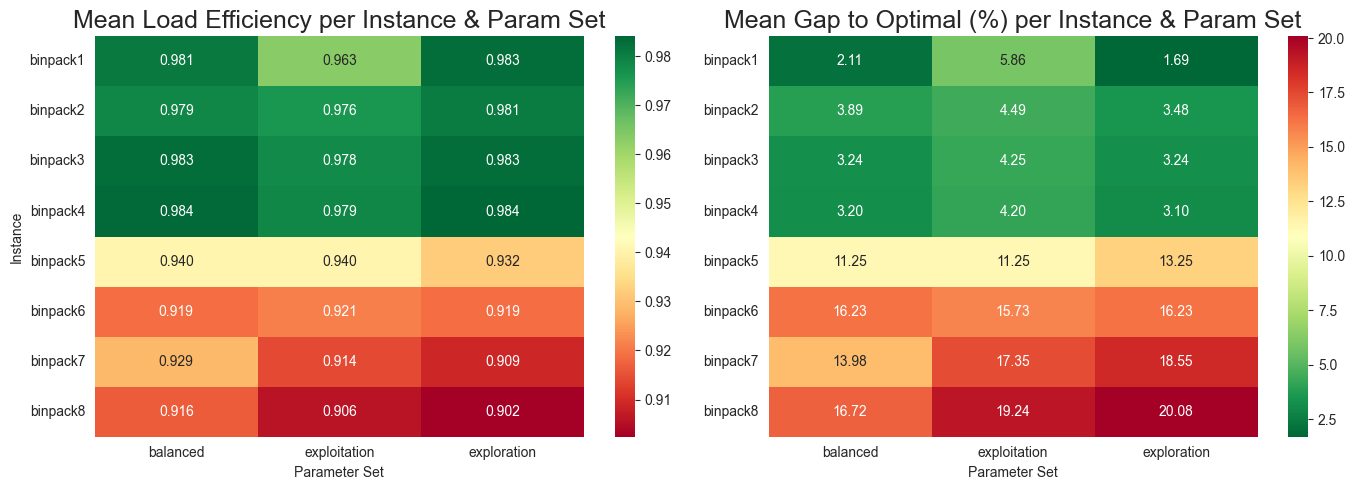

In [39]:
# calculate load efficiency
df_results_csv['load_efficiency'] = 1 - (df_results_csv['unused_capacity'] / (df_results_csv['num_bins']*df_results_csv['capacity']))


fig, ax = plt.subplots(1,2, figsize=(14,5))

# load efficiency heatmap
sns.heatmap(
    df_results_csv.groupby(['instance','param_set'])['load_efficiency'].mean().unstack(),
    annot=True, fmt=".3f", cmap='RdYlGn', ax=ax[0]
)
ax[0].set_title('Mean Load Efficiency per Instance & Param Set', fontsize=18)
ax[0].set_xlabel('Parameter Set')
ax[0].set_ylabel('Instance')

# lap to optimal heatmap
sns.heatmap(
    df_results_csv.groupby(['instance','param_set'])['gap_to_opt'].mean().unstack(),
    annot=True, fmt=".2f", cmap='RdYlGn_r', ax=ax[1]
)
ax[1].set_title('Mean Gap to Optimal (%) per Instance & Param Set', fontsize=18)
ax[1].set_xlabel('Parameter Set')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()


The instances binpack1, binpack2, binpack3 and binpack4, have the best load efficiency where the deviation from the optimal solution is around 2-5%, supporting our assumptions of the algorithm performing better when there are more items to choose from and distribute. For the other instances, the algorithm appearst to struggle more with efficient packing, and the solutions deviate 10-20% from optimal.

#### <span id="section-exploration"></span>e. Exploration vs. exploitation


In [40]:
# Ensure df_tau exists (created earlier via df_results_csv.explode('tau_std'))
# and make sure iteration column is set properly.
df_tau['iteration'] = df_tau.groupby(['instance', 'param_set', 'run']).cumcount()

# Now add the smoothed τ_std column efficiently
df_tau['tau_smooth'] = (
    df_tau.sort_values(['param_set', 'instance', 'run', 'iteration'])
    .groupby(['param_set', 'instance', 'run'])['tau_std']
    .transform(lambda x: x.rolling(5, min_periods=1).mean())
)


Plot all exploration dynamic for each parameter set:

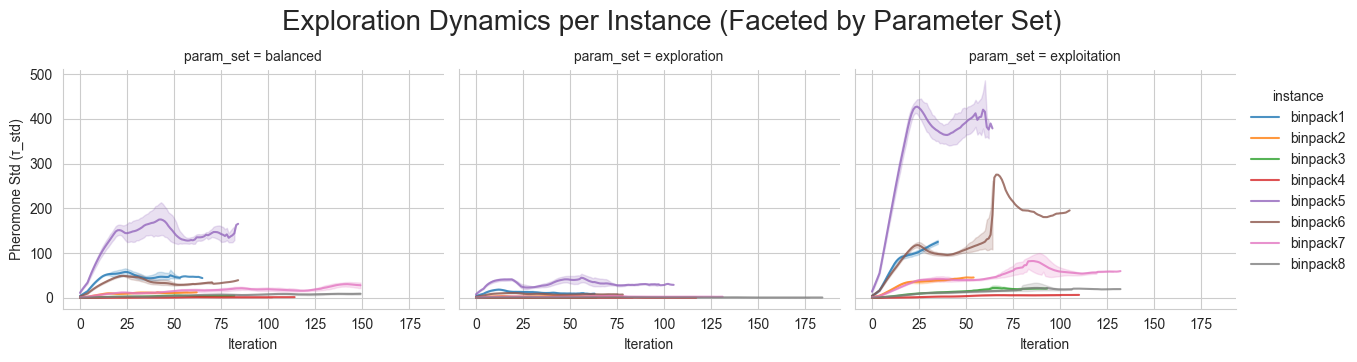

In [41]:
g = sns.FacetGrid(df_tau, col='param_set', hue='instance', col_wrap=3, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'iteration', 'tau_smooth', alpha=0.8)
g.add_legend()
g.set_axis_labels('Iteration', 'Pheromone Std (τ_std)')
g.figure.suptitle('Exploration Dynamics per Instance (Faceted by Parameter Set)', fontsize=20, y=1.02)
g.figure.subplots_adjust(top=0.85)
plt.show()

Expected distribution of pheromones where the exploitation parameter set shows a big swing in standard deviation of pheromone level, suggesting that the ants focus on different optimal areas, and explore less of the search space. The exploration data set displays an even distribution of pheromones thorught the iterations, with some extra exploration in the beginning and end.

A closer look on each parameter set:

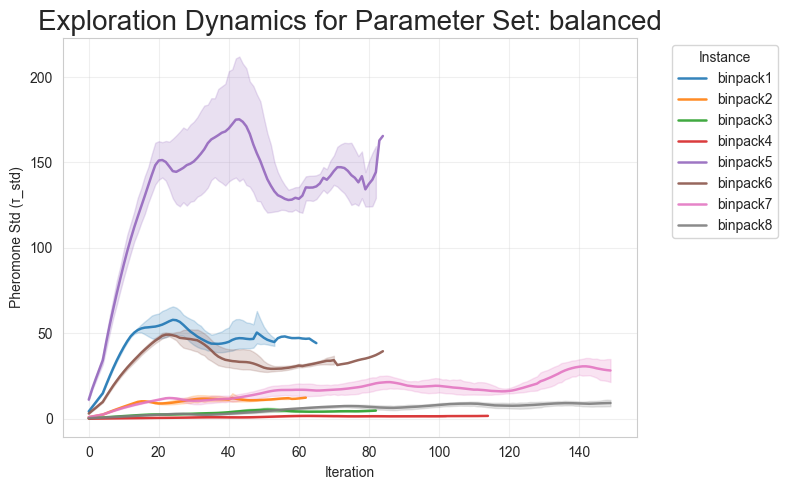

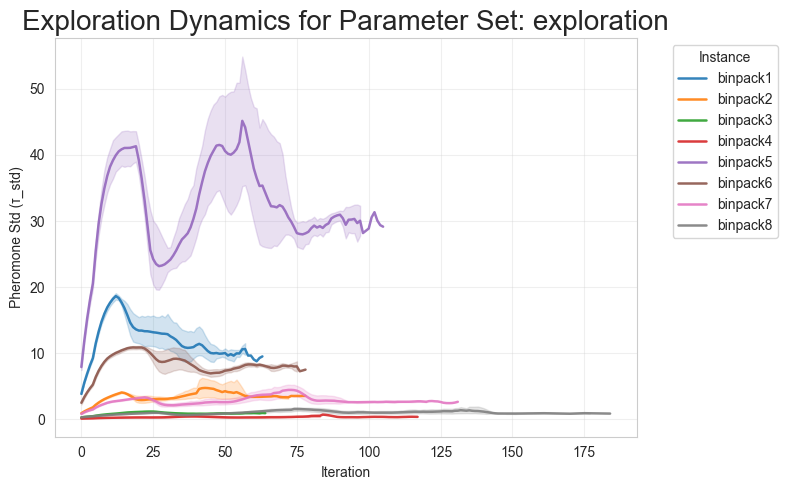

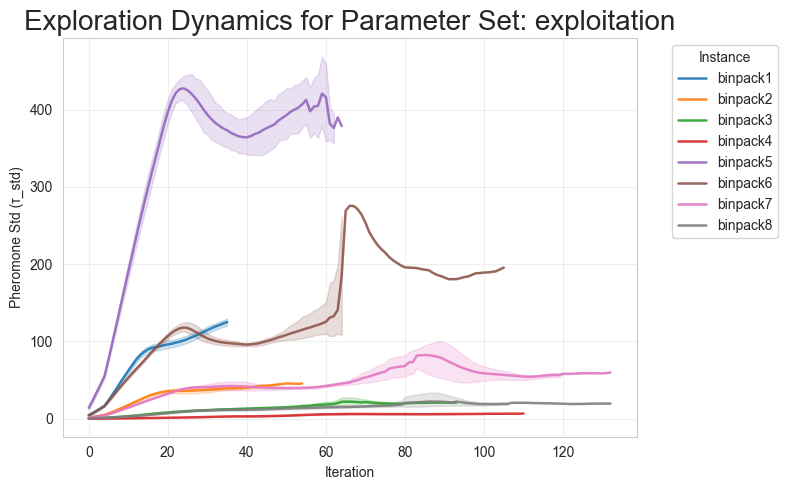

In [42]:

# get unique parameter sets
param_sets = df_tau['param_set'].unique()

for p in param_sets:
    df_sub = df_tau[df_tau['param_set'] == p]

    plt.figure(figsize=(8,5))
    sns.lineplot(
        x='iteration',
        y='tau_smooth',
        hue='instance',
        data=df_sub,
        linewidth=1.8,
        alpha=0.9
    )
    plt.title(f'Exploration Dynamics for Parameter Set: {p}', fontsize=20)
    plt.xlabel('Iteration')
    plt.ylabel('Pheromone Std (τ_std)')
    plt.legend(title='Instance', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## <span id="section-summary"></span>
# Summary

- Implemented and finalized ACO for 1-D Bin Packing using OR-Library datasets.
- Designed helper functions for data loading, parameter management, and convergence tracking.
- Ran experiments across parameter sets and visualized results to assess exploration vs exploitation trade-offs.
